# Retail pricing

**Features description**

* **customers** (integer) - monthly demand for a given subcategory of goods
* **freight_price** (float) - freight price of the company goods
* **fp1, fp2, fp3** (float) - freight price of competitors 1,2,3 goods respectively
* **product_category_name** - (categorical) - broad group category name
* **product_id** (categorical) - detailed group subcategory name
* **product_description_lenght** (integer) - Number of words in the subcategory description
* **product_score** (float) - user rating for subcategories of the company goods
* **ps1, ps2, ps3** (float) - user rating for subcategories of competitors 1,2,3 respectively
* **product_photos_qty** (integer) - number of photos for each subcategory (product_id)
* **product_weight_g** (integer) - unit weight in grams
* **total_price** (float) - montly revenue which can be calculated using formula: total_price = unit_price * qty

* **month_year** (string) - data in the format (dd-mm-yyyy) within the range between 01-01-2017 and 01-08-2018. Only months and years are important here.
* **year** (integer) - year which was taken from the 'month_year'
* **month** (integer) - month which was taken from the 'month_year'
* **qty** (integer) - monthly sales per subcategory
* **unit_price** (float) - monthly unit price of subcategory good of company goods
* **comp_1, comp_2, comp_3** (float) - unit price of within the subcategory of competitors 1,2,3 goods respectively
* **lag_price** (float) - unit price on the previous month
* **weekend** (integer) - number of weekends per month
* **weekday** (integer) - number of weekdays per month
* **holiday** (integer) - number of holidays per month
* **s** (float) - yet unknown parameter

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
#import scipy

import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import os, sys, json

from sklearn.preprocessing import  StandardScaler , OneHotEncoder, OrdinalEncoder,PolynomialFeatures 


from sklearn.model_selection import train_test_split 

#from sklearn.linear_model import LinearRegression ,ElasticNet, SGDRegressor, Lasso
from sklearn import linear_model

 
from sklearn.metrics import r2_score

from sklearn.ensemble import  GradientBoostingRegressor

from sklearn.metrics import  mean_squared_error, r2_score, mean_absolute_percentage_error, median_absolute_error, PredictionErrorDisplay

#from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

# Hides output while after model learned
from IPython.display import clear_output

# Display fixed length of a dataframe
pd.set_option("display.max_rows", 9, "display.max_columns", 9)

#set path
sys.path.insert(1, '../')

#!pip freeze > requirements.txt

In [2]:
from utils.config_reader import config_reader
from utils.figures import qq_plot,  get_comparison, annotate_scatterplot, plot_actual_vs_predicted

# Import parameters
config = config_reader('../config/config.json')

random_seed = config.random_seed
path_figures = config.path_figures

os.environ['PYTHONHASHSEED'] = str(random_seed)
np.random.seed(random_seed)

## Read files

In [3]:
data = pd.read_csv(config.data_dir + 'retail_price.zip')
data.head()

,product_id,product_category_name,month_year,qty,...,comp_3,ps3,fp3,lag_price
0,bed1,bed_bath_table,01-05-2017,1,...,45.95,4.0,15.100000,45.90
1,bed1,bed_bath_table,01-06-2017,3,...,45.95,4.0,12.933333,45.95
2,bed1,bed_bath_table,01-07-2017,6,...,45.95,4.0,14.840000,45.95
3,bed1,bed_bath_table,01-08-2017,4,...,45.95,4.0,14.287500,45.95
4,bed1,bed_bath_table,01-09-2017,2,...,45.95,4.0,15.100000,45.95


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  676 non-null    object 
 1   product_category_name       676 non-null    object 
 2   month_year                  676 non-null    object 
 3   qty                         676 non-null    int64  
 4   total_price                 676 non-null    float64
 5   freight_price               676 non-null    float64
 6   unit_price                  676 non-null    float64
 7   product_name_lenght         676 non-null    int64  
 8   product_description_lenght  676 non-null    int64  
 9   product_photos_qty          676 non-null    int64  
 10  product_weight_g            676 non-null    int64  
 11  product_score               676 non-null    float64
 12  customers                   676 non-null    int64  
 13  weekday                     676 non

In [5]:
data

,product_id,product_category_name,month_year,qty,...,comp_3,ps3,fp3,lag_price
0,bed1,bed_bath_table,01-05-2017,1,...,45.95,4.0,15.100000,45.900000
1,bed1,bed_bath_table,01-06-2017,3,...,45.95,4.0,12.933333,45.950000
2,bed1,bed_bath_table,01-07-2017,6,...,45.95,4.0,14.840000,45.950000
3,bed1,bed_bath_table,01-08-2017,4,...,45.95,4.0,14.287500,45.950000
...,...,...,...,...,...,...,...,...,...
672,bed5,bed_bath_table,01-06-2017,10,...,45.95,4.0,12.933333,215.000000
673,bed5,bed_bath_table,01-07-2017,59,...,45.95,4.0,14.840000,209.000000
674,bed5,bed_bath_table,01-08-2017,52,...,45.95,4.0,14.287500,205.000000
675,bed5,bed_bath_table,01-09-2017,32,...,45.95,4.0,15.100000,199.509804


In [6]:
any(data.isna().sum())#.value_counts()

False

> The dataset does not contain missing entries.

# 1. EDA

In [7]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

num_features = [s for s in data.columns if data[s].dtypes in numerics]
cat_features = [s for s in data.columns if data[s].dtypes == 'object' or data[s].dtypes == 'category']
print(num_features)

['qty', 'total_price', 'freight_price', 'unit_price', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_score', 'customers', 'weekday', 'weekend', 'holiday', 'month', 'year', 's', 'volume', 'comp_1', 'ps1', 'fp1', 'comp_2', 'ps2', 'fp2', 'comp_3', 'ps3', 'fp3', 'lag_price']


### month_year, month, year

In [8]:
type(data['month_year'].iloc[0])

str

In [9]:
data[['month_year', 'month','year']].head()

,month_year,month,year
0,01-05-2017,5,2017
1,01-06-2017,6,2017
2,01-07-2017,7,2017
3,01-08-2017,8,2017
4,01-09-2017,9,2017


In [10]:
data['year'] = pd.to_datetime(data['month_year'], format='%d-%m-%Y').dt.year 
data['month'] = pd.to_datetime(data['month_year'], format='%d-%m-%Y').dt.month
data['month_year'] = pd.to_datetime(data['month_year'], format='%d-%m-%Y').dt.strftime('%Y-%m') #.dt.to_period('m')
#data['day'] = pd.to_datetime(data['month_year']).dt.day
data['month_year'].head()

0    2017-05
1    2017-06
2    2017-07
3    2017-08
4    2017-09
Name: month_year, dtype: object

In [11]:
idx = sorted(list(data['month_year'].unique()))
idx

['2017-01',
 '2017-02',
 '2017-03',
 '2017-04',
 '2017-05',
 '2017-06',
 '2017-07',
 '2017-08',
 '2017-09',
 '2017-10',
 '2017-11',
 '2017-12',
 '2018-01',
 '2018-02',
 '2018-03',
 '2018-04',
 '2018-05',
 '2018-06',
 '2018-07',
 '2018-08']

In [12]:
data[['month_year', 'month','year']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   month_year  676 non-null    object
 1   month       676 non-null    int64 
 2   year        676 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 16.0+ KB


### unit_price (target feature)

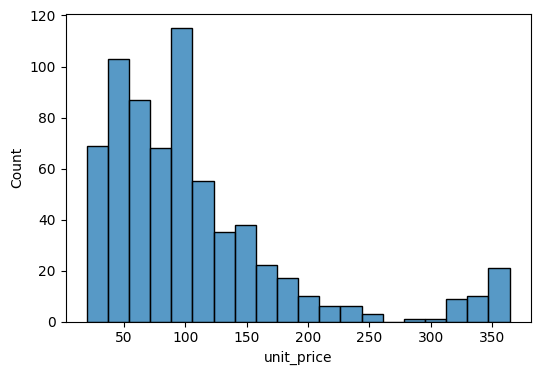

In [13]:
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(data['unit_price']); #,bins=15

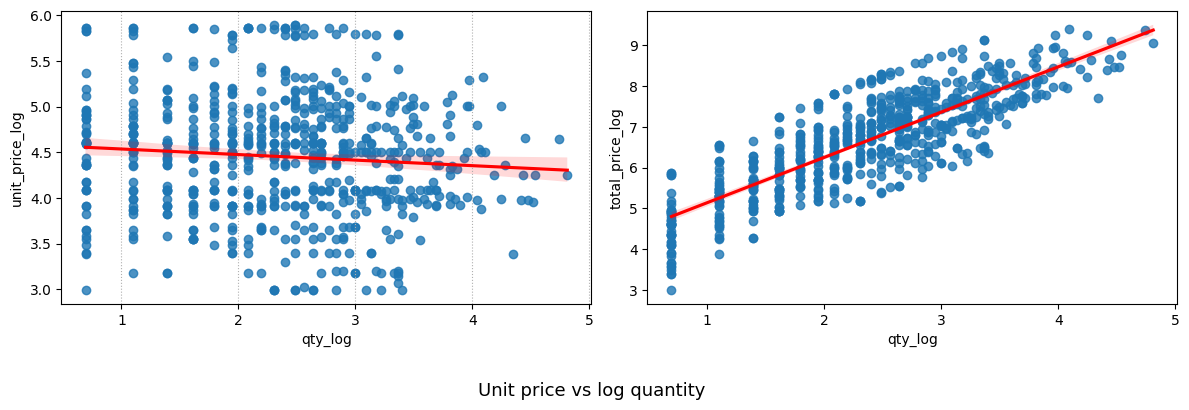

In [14]:
data['total_price_log'] = np.log(data['total_price'])
data['unit_price_log'] = np.log(data['unit_price'])
data['qty_log'] = np.log(data['qty'] + 1)

fig, ax = plt.subplots(1,2, figsize=(12, 4))
#fig = sns.histplot(data['qty_log'], ax=ax[0]); #,bins=15
sns.regplot(data, y='unit_price_log', x='qty_log', ax=ax[0] , line_kws={"color": "red"}) #
sns.regplot(data, y='total_price_log', x='qty_log', ax=ax[1] , line_kws={"color": "red"})
#ax[0].set_yscale('log')

ax[0].xaxis.grid(linestyle=':')
plot_counter=1
fig.suptitle('Unit price vs log quantity ', y=-0.05, fontsize=13) #, loc='right'
plt.tight_layout()

#plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

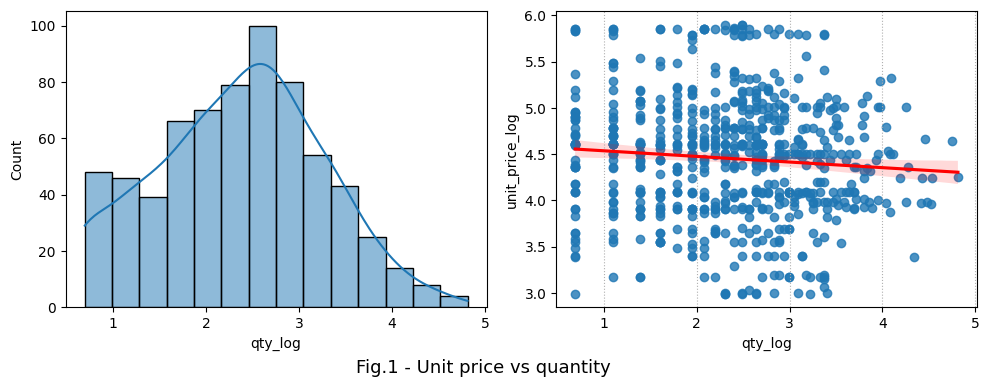

In [15]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))


fig = sns.histplot(data['qty_log'], ax=ax[0], kde=True); #,bins=15
fig = sns.regplot(data, y='unit_price_log', ax=ax[1], x='qty_log', line_kws={"color": "red"}) #
ax[1].xaxis.grid(linestyle=':')

plot_counter=1
ax[0].set_title('Fig.1 - Unit price vs quantity ', y=-0.25, fontsize=13, x=1) #
plt.tight_layout()

plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

> It is essential that unit price is discounted in case of wholesale.

### 'unit_price' vs 'comp_1', 'comp_2', 'comp_3'

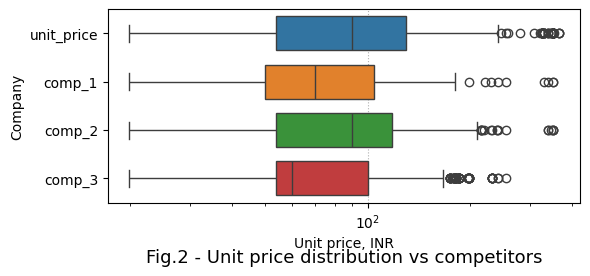

In [16]:
plot_counter = 2
fig, ax = plt.subplots( figsize=(6,3))
sns.boxplot(data[['unit_price', 'comp_1', 'comp_2', 'comp_3']], width=0.7, orient='h')  
ax.xaxis.grid(linestyle=':')
ax.set_xscale('log')
ax.set_xlabel('Unit price, INR')
ax.set_ylabel('Company')
    
ax.set_title(f'Fig.{plot_counter} - Unit price distribution vs competitors', y=-0.35, fontsize=13, loc='center')
plt.tight_layout();

plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

In [17]:
data[['unit_price', 'comp_1', 'comp_2', 'comp_3']].median()

unit_price    89.90
comp_1        69.90
comp_2        89.99
comp_3        59.90
dtype: float64

In [18]:
data[['comp_1', 'comp_2', 'comp_3']] = data[['comp_1', 'comp_2', 'comp_3']].apply(np.log)

### freight_price, fp1,fp2, fp3

In [19]:
data[['freight_price', 'fp1', 'fp2', 'fp3']].head()

,freight_price,fp1,fp2,fp3
0,15.100000,15.011897,8.760000,15.100000
1,12.933333,14.769216,21.322000,12.933333
2,14.840000,13.993833,22.195932,14.840000
3,14.287500,14.656757,19.412885,14.287500
4,15.100000,18.776522,24.324687,15.100000


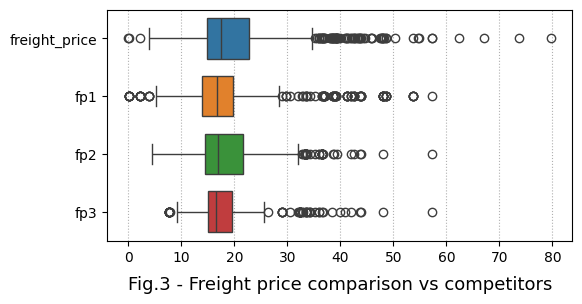

In [20]:
plot_counter = 3
fig, ax = plt.subplots( figsize=(6,3))
sns.boxplot(data[['freight_price', 'fp1', 'fp2', 'fp3']], width=0.7, orient='h')  
ax.xaxis.grid(linestyle=':')
#ax.set_xscale('log')

ax.set_title(f'Fig.{plot_counter} - Freight price comparison vs competitors', y=-0.25, fontsize=13, loc='center');


plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

In [21]:
mask = data['freight_price']<4
data[mask]

,product_id,product_category_name,month_year,qty,...,lag_price,total_price_log,unit_price_log,qty_log
276,watches6,watches_gifts,2018-04,85,...,117.441290,9.100692,4.660119,4.454347
277,watches6,watches_gifts,2018-05,114,...,105.648625,9.377565,4.642394,4.744932
388,watches5,watches_gifts,2018-05,17,...,204.384615,8.126518,5.293305,2.890372
503,furniture2,furniture_decor,2018-05,92,...,69.900000,8.768854,4.247066,4.532599


In [22]:
data['freight_price'].describe()

count    676.000000
mean      20.682270
std       10.081817
min        0.000000
25%       14.761912
50%       17.518472
75%       22.713558
max       79.760000
Name: freight_price, dtype: float64

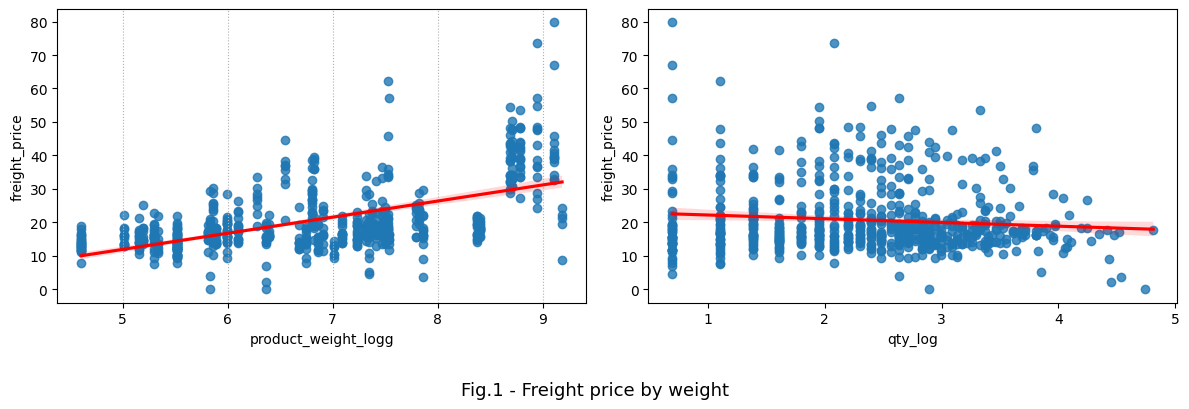

In [23]:
data['product_weight_logg'] = np.log(data['product_weight_g'])

fig, ax = plt.subplots(1,2, figsize=(12, 4))
#fig = sns.histplot(data['qty_log'], ax=ax[0]); #,bins=15
sns.regplot(data, x='product_weight_logg', y='freight_price', ax=ax[0] , line_kws={"color": "red"}) #
sns.regplot(data, x='qty_log', y='freight_price', ax=ax[1] , line_kws={"color": "red"})
#ax[0].set_yscale('log')

ax[0].xaxis.grid(linestyle=':')
plot_counter=1
fig.suptitle('Fig.1 - Freight price by weight', y=-0.05, fontsize=13) #, loc='right'
plt.tight_layout() 

### qty

In [24]:
data['qty']

0       1
1       3
2       6
3       4
       ..
672    10
673    59
674    52
675    32
Name: qty, Length: 676, dtype: int64

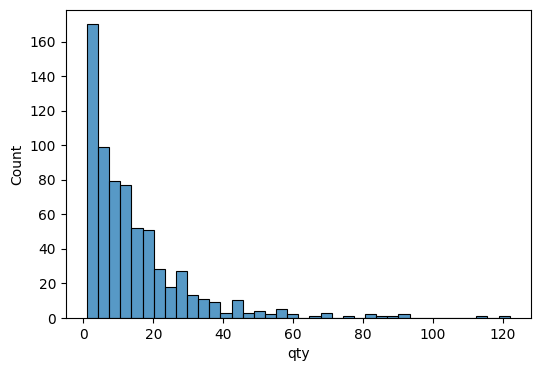

In [25]:
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(data['qty']); #,bins=15

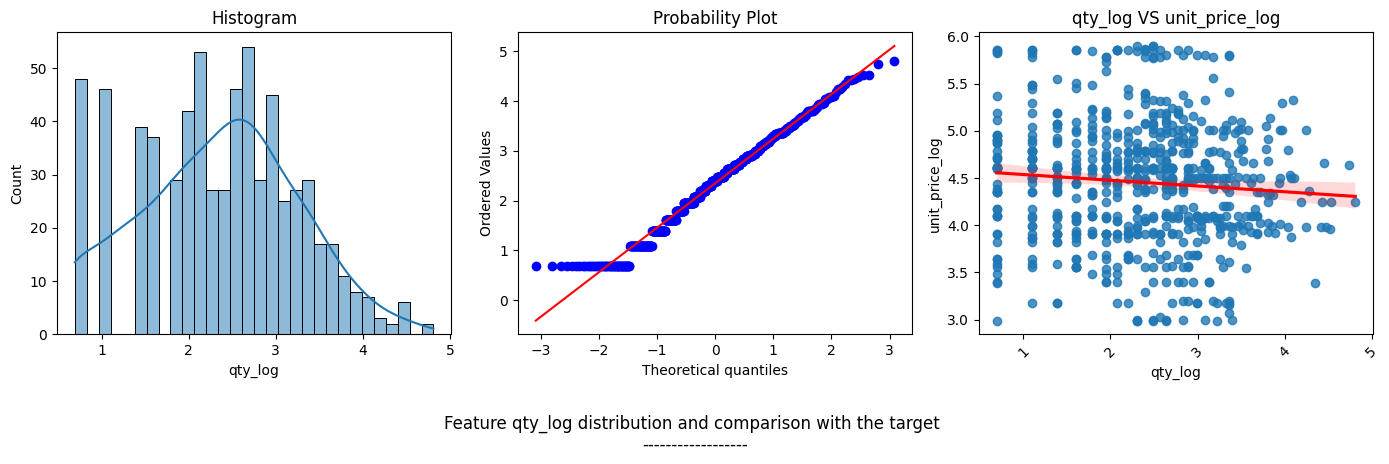

In [26]:
qq_plot(data, ['qty_log'], 'unit_price_log')

In [27]:
temp = data.pivot_table(
    values='qty',
    index='product_category_name',
    columns='month_year',
    aggfunc='sum')

#temp = temp[idx]
temp 

month_year,2017-01,2017-02,2017-03,2017-04,...,2018-05,2018-06,2018-07,2018-08
product_category_name,,,,,,,,,
bed_bath_table,NaN,2.0,22.0,34.0,...,61.0,46.0,29.0,16.0
computers_accessories,NaN,3.0,3.0,5.0,...,88.0,71.0,50.0,18.0
consoles_games,NaN,NaN,NaN,NaN,...,3.0,2.0,1.0,NaN
cool_stuff,NaN,7.0,22.0,33.0,...,4.0,2.0,NaN,1.0
furniture_decor,NaN,NaN,NaN,NaN,...,120.0,27.0,26.0,29.0
garden_tools,NaN,3.0,22.0,23.0,...,153.0,77.0,61.0,54.0
health_beauty,9.0,20.0,26.0,23.0,...,172.0,136.0,122.0,133.0
perfumery,NaN,NaN,NaN,NaN,...,17.0,14.0,13.0,21.0
watches_gifts,NaN,NaN,6.0,3.0,...,280.0,99.0,125.0,61.0


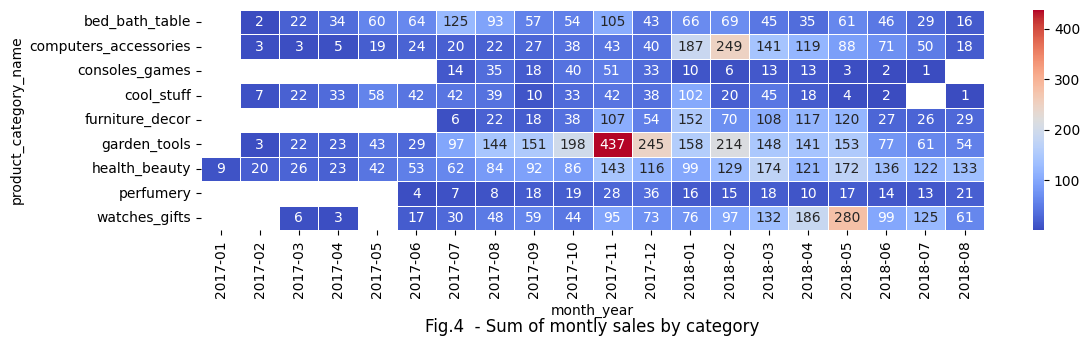

In [28]:
plot_counter = 4

#mask = data['product_category_name']!='garden_tools'
temp = data.pivot_table(
    values='qty',
    index='product_category_name',
    columns='month_year',
    aggfunc='sum') 

means =  temp.loc[:,:'2017-12'].T.mean()
#temp = temp.values / means

fig,ax = plt.subplots(figsize=(12, 4))

fig = sns.heatmap(temp, annot=True, fmt='.0f',  linewidths=.5, cmap= 'coolwarm') #vmin=-1, vmax=1, fmt='.1g'center= 0,

ax.set_title(f'Fig.{plot_counter}  - Sum of montly sales by category', y=-0.5, fontsize=12);
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()

plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

### product_id 

In [29]:
display(f"Number of unique categories: {data['product_id'].nunique()}")
data['product_id'].value_counts()

'Number of unique categories: 52'

health5     20
health7     20
bed2        19
garden1     18
            ..
cool3        7
health10     7
health6      7
bed5         5
Name: product_id, Length: 52, dtype: int64

In [30]:
mask = data['product_id']=='health5'
data[mask].sort_values(by=['month_year'])

,product_id,product_category_name,month_year,qty,...,total_price_log,unit_price_log,qty_log,product_weight_logg
339,health5,health_beauty,2017-01,8,...,7.937089,5.857647,2.197225,6.802395
340,health5,health_beauty,2017-02,4,...,7.243942,5.857647,1.609438,6.802395
341,health5,health_beauty,2017-03,2,...,6.550795,5.857647,1.098612,6.802395
342,health5,health_beauty,2017-04,1,...,5.857647,5.857647,0.693147,6.802395
...,...,...,...,...,...,...,...,...,...
355,health5,health_beauty,2018-05,10,...,8.164254,5.864341,2.397895,6.802395
356,health5,health_beauty,2018-06,11,...,8.295049,5.897154,2.484907,6.802395
357,health5,health_beauty,2018-07,11,...,8.295049,5.897154,2.484907,6.802395
358,health5,health_beauty,2018-08,9,...,8.094378,5.897154,2.302585,6.802395


In [31]:
temp = data['product_id'].str.split('([A-Za-z]+)', expand=True)#.iloc[:,1] #(\d+)
#display(temp)
data['product_subcategory'] = temp[2].astype('category')
temp[1].value_counts()

garden       160
health       130
watches      103
computers     69
bed           61
cool          57
furniture     48
perfumery     26
consoles      22
Name: 1, dtype: int64

### product_category_name

In [32]:
data['product_category_name'].value_counts()

garden_tools             160
health_beauty            130
watches_gifts            103
computers_accessories     69
bed_bath_table            61
cool_stuff                57
furniture_decor           48
perfumery                 26
consoles_games            22
Name: product_category_name, dtype: int64

> This feature duplicates with the previous one so it should be deleted

In [33]:
data['product_category_name'] = data['product_category_name'].astype('category')

#data['product_category_name']

### customers

In [34]:
data['customers']

0       57
1       61
2      123
3       90
      ... 
672     61
673    123
674     90
675     54
Name: customers, Length: 676, dtype: int64

In [35]:
mask = data['product_id']=='bed1'
any(data[mask].groupby(['month_year'])['customers'].min() == data[mask].groupby(['month_year'])['customers'].max())

True

In [36]:
data[['total_price', 'volume','customers', 'unit_price','s','qty']]

,total_price,volume,customers,unit_price,s,qty
0,45.95,3800,57,45.950000,10.267394,1
1,137.85,3800,61,45.950000,6.503115,3
2,275.70,3800,123,45.950000,12.071651,6
3,183.80,3800,90,45.950000,9.293873,4
...,...,...,...,...,...,...
672,2090.00,12600,61,209.000000,6.493506,10
673,12095.00,12600,123,205.000000,38.311688,59
674,10375.00,12600,90,199.509804,33.766234,52
675,5222.36,12600,54,163.398710,20.779221,32


> The feature represents monthly demand for every product subcategory

### 'weekday','weekend', 'holiday'

In [37]:
data.groupby(['month_year'])[['weekday','weekend', 'holiday']].min().head(9)

,weekday,weekend,holiday
month_year,,,
2017-01,22,9,1
2017-02,20,8,2
2017-03,23,8,1
2017-04,20,10,2
2017-05,23,8,1
2017-06,22,8,1
2017-07,21,10,1
2017-08,23,8,1
2017-09,21,9,1


In [38]:
any(data.groupby(['month_year'])['weekday'].min() == data.groupby(['month_year'])['weekday']. max())

True

### product_description_lenght

In [39]:
temp = list(data['product_description_lenght'].unique())
temp = sorted(temp)

print(temp)

[100, 161, 162, 178, 236, 237, 245, 256, 272, 300, 312, 319, 339, 340, 341, 348, 363, 366, 388, 409, 450, 492, 501, 514, 523, 575, 591, 625, 640, 735, 787, 789, 829, 894, 897, 903, 995, 1012, 1257, 1456, 1495, 1536, 1893, 2188, 2644, 3006]


In [40]:
any(data.groupby(['product_id'])['product_description_lenght'].min() == data.groupby(['product_id'])['product_description_lenght'].max())

True

In [41]:
data['product_description_enc'] = pd.cut(data.product_description_lenght, [0,250,500,750,1000,1500,2000,2500,9999], labels = ['<250','500','750','1000','1500','2000','2500','>2500'])
data['product_description_enc']

0      <250
1      <250
2      <250
3      <250
       ... 
672    <250
673    <250
674    <250
675    <250
Name: product_description_enc, Length: 676, dtype: category
Categories (8, object): ['<250' < '500' < '750' < '1000' < '1500' < '2000' < '2500' < '>2500']

In [42]:
data[['product_description_lenght','product_description_enc']].info()
#data.drop(['product_description_lenght'], axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   product_description_lenght  676 non-null    int64   
 1   product_description_enc     676 non-null    category
dtypes: category(1), int64(1)
memory usage: 6.4 KB


### 'lag_price'

In [43]:
data[['month_year', 'lag_price', 'unit_price']]

,month_year,lag_price,unit_price
0,2017-05,45.900000,45.950000
1,2017-06,45.950000,45.950000
2,2017-07,45.950000,45.950000
3,2017-08,45.950000,45.950000
...,...,...,...
672,2017-06,215.000000,209.000000
673,2017-07,209.000000,205.000000
674,2017-08,205.000000,199.509804
675,2017-09,199.509804,163.398710


In [44]:
mask = (data['product_id']=='bed1')
print(data[mask].groupby(['month_year'])[['unit_price', 'lag_price']].mean().values)

mask = (data['product_id']=='bed1')
data[mask].groupby(['month_year'])['unit_price'].min()[:-1].values == data[mask].groupby(['month_year'])['lag_price'].max()[1:].values

[[45.95       45.9       ]
 [45.95       45.95      ]
 [45.95       45.95      ]
 [45.95       45.95      ]
 [45.95       45.95      ]
 [45.95       45.95      ]
 [40.53181818 45.95      ]
 [39.99       40.53181818]
 [39.99       39.99      ]
 [39.99       39.99      ]
 [39.99       39.99      ]
 [39.99       39.99      ]
 [39.99       39.99      ]
 [39.99       39.99      ]
 [39.99       39.99      ]
 [39.24       39.99      ]]


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [45]:
data['lag_price'].corr(data['unit_price'])

0.9944534285112646

> Let us compare this feature with the unit_price. As it can be seen, they are almost identical.
> Lag price has a very high correlation with the unit_price.  Hence it should be dropped.

### 'product_photos_qty'

In [46]:
data['product_photos_qty'].value_counts()

1    338
2    186
3     65
4     39
6     26
5     15
8      7
Name: product_photos_qty, dtype: int64

In [47]:
temp = data.groupby(['product_id'])['product_photos_qty'].agg(['min','max']).values.flatten()
print(temp)
np.where(temp != temp.round())

[2 2 1 1 1 1 5 5 5 5 1 1 1 1 1 1 1 1 1 1 1 1 4 4 3 3 1 1 1 1 8 8 1 1 1 1 1
 1 6 6 1 1 1 1 1 1 2 2 2 2 1 1 2 2 1 1 2 2 2 2 2 2 2 2 3 3 1 1 6 6 1 1 1 1
 1 1 1 1 2 2 3 3 1 1 2 2 1 1 2 2 3 3 4 4 2 2 1 1 3 3 4 4 1 1]


(array([], dtype=int64),)

> All numbers are integer, and minimums are equal to maximums. Therefore, each category has a dtermined number of photos

### product_weight_g

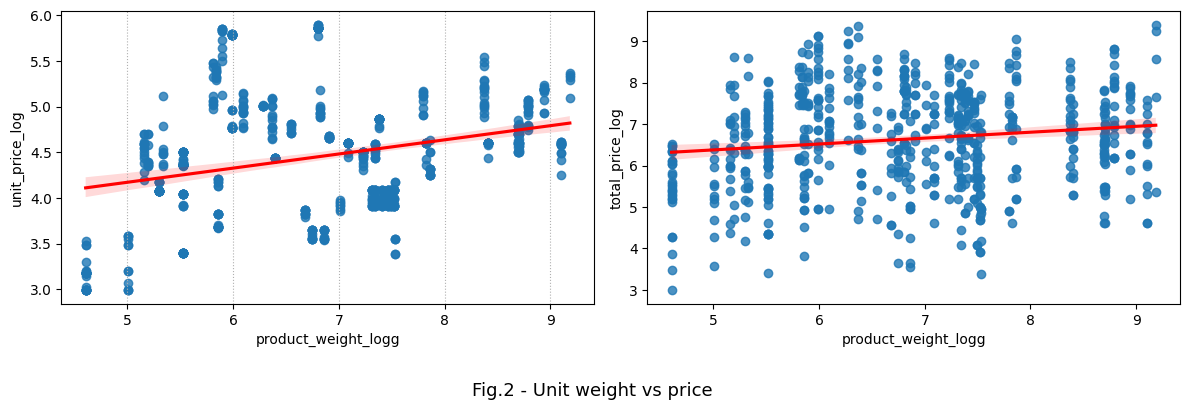

In [48]:
data['product_weight_logg'] = np.log(data['product_weight_g'])

fig, ax = plt.subplots(1,2, figsize=(12, 4))
#fig = sns.histplot(data['qty_log'], ax=ax[0]); #,bins=15
sns.regplot(data, x='product_weight_logg', y='unit_price_log', ax=ax[0] , line_kws={"color": "red"}) #
sns.regplot(data, x='product_weight_logg', y='total_price_log', ax=ax[1] , line_kws={"color": "red"})
#ax[0].set_yscale('log')

ax[0].xaxis.grid(linestyle=':')
plot_counter=1
fig.suptitle('Fig.2 - Unit weight vs price ', y=-0.05, fontsize=13) #, loc='right'
plt.tight_layout() 

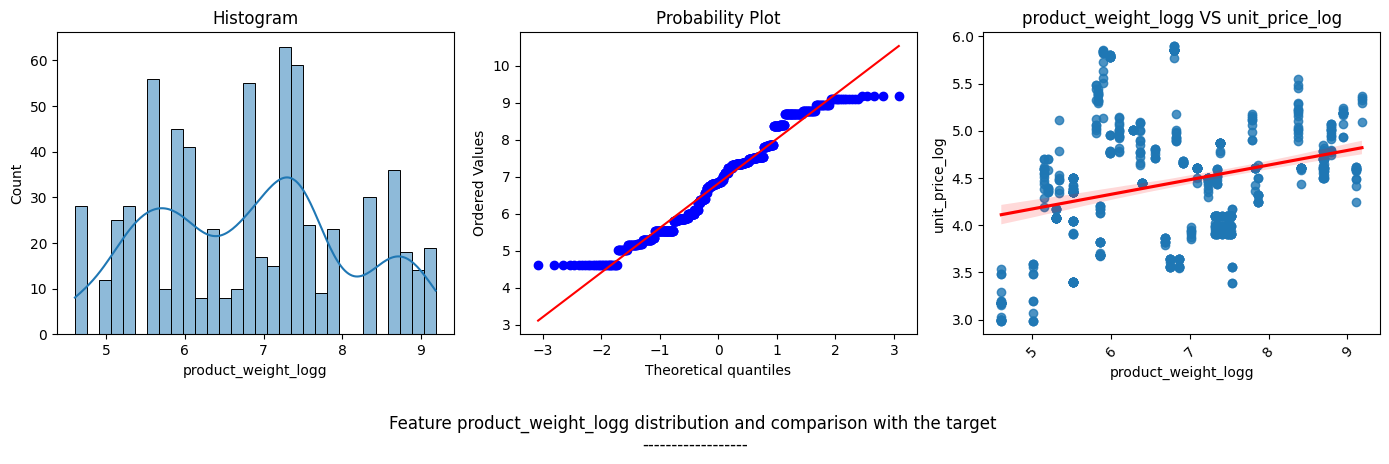

In [49]:
qq_plot(data, ['product_weight_logg'], 'unit_price_log')

In [50]:
data[['product_weight_g']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   product_weight_g  676 non-null    int64
dtypes: int64(1)
memory usage: 5.4 KB


### product_score, ps1, ps2, ps3

In [51]:
data['product_score'].value_counts()

4.2    155
4.1    120
4.3    120
3.9     71
      ... 
3.7     25
3.5     18
3.3     11
4.5     11
Name: product_score, Length: 11, dtype: int64

In [52]:
any(data.groupby(['product_id'])['product_score'].min() == data.groupby(['product_id'])['product_score'].max())

True

In [53]:
data[['product_score', 'ps1', 'ps2', 'ps3']]

,product_score,ps1,ps2,ps3
0,4.0,3.9,4.4,4.0
1,4.0,3.9,4.4,4.0
2,4.0,3.9,4.4,4.0
3,4.0,3.9,4.4,4.0
...,...,...,...,...
672,4.4,3.9,4.4,4.0
673,4.4,3.9,4.4,4.0
674,4.4,3.9,4.4,4.0
675,4.4,3.9,4.4,4.0


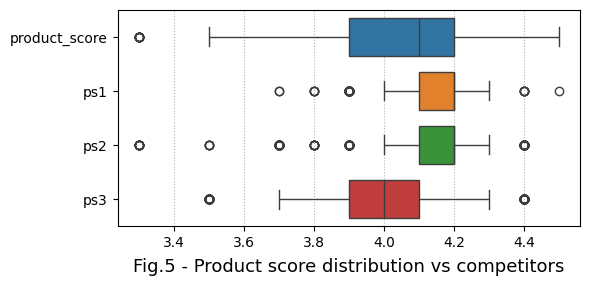

In [54]:
plot_counter = 5
fig, ax = plt.subplots( figsize=(6,3))
sns.boxplot(data[['product_score','ps1', 'ps2', 'ps3']], width=0.7, orient='h')  
ax.xaxis.grid(linestyle=':')

ax.set_title(f'Fig.{plot_counter} - Product score distribution vs competitors', y=-0.25, fontsize=13, loc='center')
 
plt.tight_layout()

plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

In [55]:
any(data.groupby(['product_id'])['ps1'].min() == data.groupby(['product_id'])['ps1'].max())

True

In [56]:
#data['product_score'] = data['product_score'].astype('category')
for i in ['product_score', 'ps1', 'ps2', 'ps3']:
    data[i] = data[i].astype('category')

### S

In [57]:
data['s']

0      10.267394
1       6.503115
2      12.071651
3       9.293873
         ...    
672     6.493506
673    38.311688
674    33.766234
675    20.779221
Name: s, Length: 676, dtype: float64

In [58]:
data.groupby(['product_id'])['s'].agg(['min', 'max', 'mean'])

,min,max,mean
product_id,,,
bed1,5.555556,30.555556,12.500000
bed2,3.899721,18.234244,10.526316
bed3,1.351351,59.459459,18.181818
bed4,3.448276,43.835616,20.000000
...,...,...,...
watches5,12.121212,42.424242,20.000000
watches6,1.515152,44.357977,14.285714
watches7,1.111111,50.000000,16.666667
watches8,1.769912,50.000000,20.000000


# Feature engineering

## preparation

In [59]:
data_copy = data.copy()
data_copy.drop(['product_id','month_year', 'year', 'qty', 'lag_price', 'unit_price','total_price', 'total_price_log', 'product_category_name', 'product_subcategory','product_description_lenght', 'product_weight_g'], axis=1, inplace=True) #  'month',

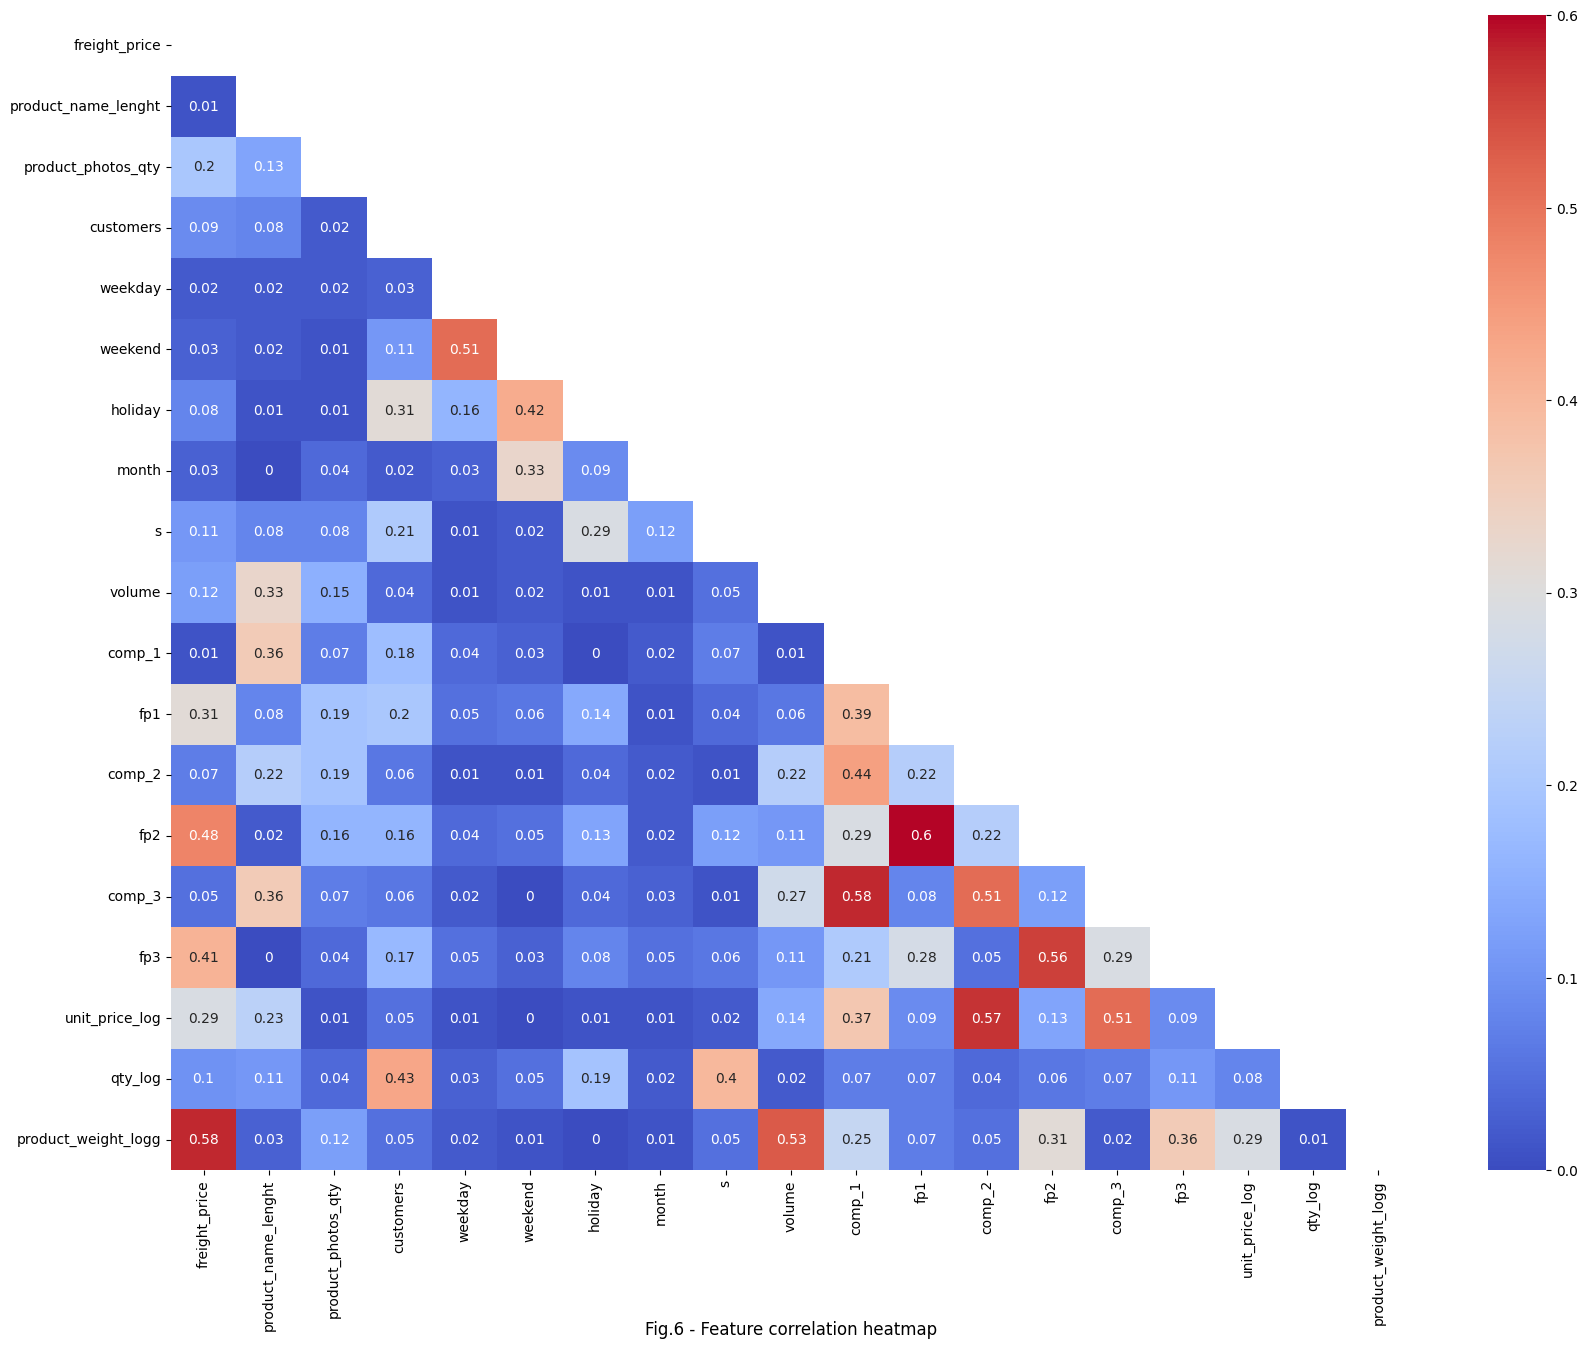

In [60]:
plot_counter = 6
fig, ax = plt.subplots(figsize=(20, 15))

matrix = np.triu(data_copy.corr())  
fig = sns.heatmap(round(abs(data_copy.corr()),2), annot=True,  cmap= 'coolwarm', mask=matrix) #, vmin=-1, vmax=1, center= 0, fmt='.02g',
ax.set_title(f'Fig.{plot_counter} - Feature correlation heatmap', y=-0.15, fontsize=12)
plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

In [61]:
data_copy.columns

Index(['freight_price', 'product_name_lenght', 'product_photos_qty',
       'product_score', 'customers', 'weekday', 'weekend', 'holiday', 'month',
       's', 'volume', 'comp_1', 'ps1', 'fp1', 'comp_2', 'ps2', 'fp2', 'comp_3',
       'ps3', 'fp3', 'unit_price_log', 'qty_log', 'product_weight_logg',
       'product_description_enc'],
      dtype='object')

### Missing values

In [62]:
data_copy.isna().sum().value_counts(ascending=False)

0    24
dtype: int64

### Encoding

In [63]:
# X,y =  data.drop(['unit_price'], axis=1), data['unit_price']
X,y =  data_copy.drop(['unit_price_log'], axis=1), data_copy['unit_price_log']

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

num_features = [s for s in X.columns if X[s].dtypes in numerics]
cat_features = [s for s in X.columns if X[s].dtypes == 'object' or X[s].dtypes == 'category']

#ord_features = ['product_description_enc', 'product_score', 'ps1', 'ps2', 'ps3']
#cat_features = ['calendar_weekend']
print(num_features)

['freight_price', 'product_name_lenght', 'product_photos_qty', 'customers', 'weekday', 'weekend', 'holiday', 'month', 's', 'volume', 'comp_1', 'fp1', 'comp_2', 'fp2', 'comp_3', 'fp3', 'qty_log', 'product_weight_logg']


In [64]:
transformer = make_column_transformer(
    (StandardScaler(), num_features),
    #(OneHotEncoder(sparse=False, drop='if_binary'), cat_features), remainder = 'passthrough') 
    (OrdinalEncoder(), cat_features),
    #(OneHotEncoder(sparse=False, drop='if_binary'), cat_features), remainder = 'passthrough'
)

 
transformer = transformer.fit(X)
results = transformer.transform(X)

results = pd.DataFrame(results, columns=\
    transformer.transformers_[0][1].get_feature_names_out().tolist() \
    + transformer.transformers_[1][1].get_feature_names_out().tolist() \
    #+ transformer.transformers_[2][1].get_feature_names_out().tolist()
    )

results.shape

(676, 23)

In [65]:
# Split data by 3 samples: train, test and valid
X_train, X_valid, y_train, y_valid = train_test_split(results, y, test_size=0.2,  random_state=random_seed)
X_test, X_valid, y_test, y_valid  = train_test_split(X_valid, y_valid, test_size=0.5, random_state=random_seed)

# Check samples shapes
print('Train shape: {}'.format(X_train.shape))
print('Test shape:  {}'.format(X_test.shape))
print('Valid shape: {}'.format(X_valid.shape))


Train shape: (540, 23)
Test shape:  (68, 23)
Valid shape: (68, 23)


In [66]:
X_train

,freight_price,product_name_lenght,product_photos_qty,customers,...,ps1,ps2,ps3,product_description_enc
218,-0.365178,-1.457487,0.708681,-0.129465,...,5.0,7.0,2.0,5.0
18,1.907341,-1.351260,-0.700344,-0.758400,...,4.0,7.0,5.0,4.0
567,1.330215,0.985749,-0.700344,-0.564882,...,4.0,7.0,5.0,2.0
408,-0.853547,1.091976,0.004169,0.741367,...,6.0,6.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...
106,0.048413,0.560838,-0.700344,-0.774526,...,5.0,8.0,7.0,0.0
270,-0.659214,-1.669943,0.708681,-0.435869,...,5.0,7.0,2.0,5.0
435,2.035240,-0.182756,-0.700344,-0.371363,...,4.0,7.0,5.0,2.0
102,-0.544535,0.560838,0.004169,-1.016424,...,6.0,9.0,7.0,2.0


# 2. Modelling

In [67]:
# dictionary to record models properties
results = {'model_name': [], 'MSE':[], 'MAPE': []}

### Linear regression with Stochastic gradient descent

In [68]:
# Creation an instance
lin_sgd = linear_model.SGDRegressor(random_state=random_seed)

# Train the Model
lin_sgd.fit(X_train, y_train)

# Predict target values
y_pred_train, y_pred_test = lin_sgd.predict(X_train), lin_sgd.predict(X_test)

y_pred_train, y_pred_test = np.exp(y_pred_train), np.exp(y_pred_test)

results['model_name'].append('lin_reg')
results['MSE'].append(round(mean_squared_error(np.exp(y_test), y_pred_test),2))
results['MAPE'].append(round(mean_absolute_percentage_error(np.exp(y_test), y_pred_test)*100,2))

print('MAPE: {:.2f} %'.format(mean_absolute_percentage_error(np.exp(y_test), y_pred_test)*100))

#print("Train R^2: {:.3f}".format(r2_score(np.exp(y_train), y_pred_train)))
#print("Test R^2: {:.3f}".format(r2_score(np.exp(y_test), y_pred_test)))

MAPE: 46.69 %


In [69]:
print(f'Median abs error: {round(median_absolute_error(y_test, y_pred_test),2)}')

Median abs error: 65.92


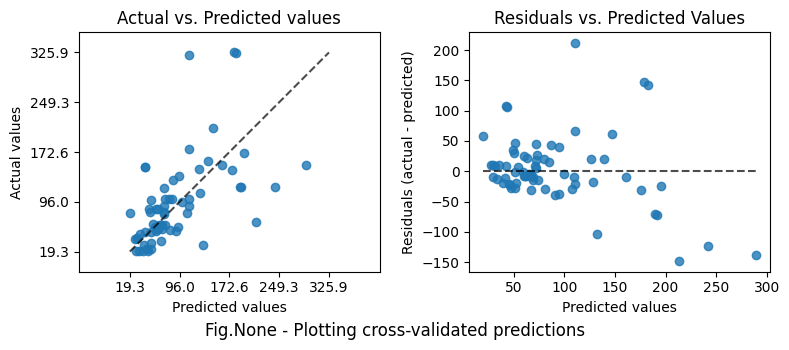

In [70]:
plot_actual_vs_predicted(np.exp(y_test), y_pred_test)   

In [71]:
# Features and coefficients
coef_df = pd.DataFrame({'Coefficients': lin_sgd.coef_}, index=X_train.columns)
coef_df
# add the intercept coefficient
coef_df.loc['INTERCEPT'] = lin_sgd.intercept_
display(coef_df.sort_values('Coefficients',ascending=False))

,Coefficients
INTERCEPT,1.612828
ps1,0.470889
product_weight_logg,0.411907
comp_1,0.361154
...,...
s,-0.050124
product_score,-0.050385
comp_3,-0.093896
fp2,-0.148994


<Axes: ylabel='None'>

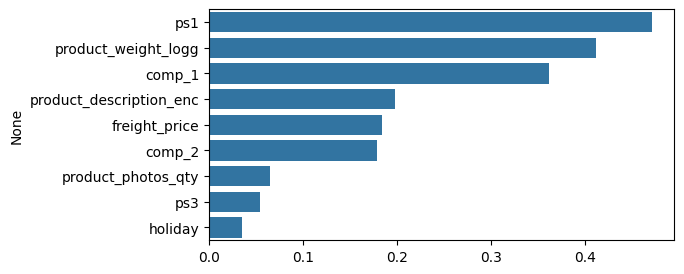

In [72]:
temp = coef_df.sort_values('Coefficients',ascending=False)

plot_counter = 8
fig, ax = plt.subplots( figsize=(6,3))
sns.barplot(x=temp.values.flatten()[1:10], y=temp.index[1:10])
 
#plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

> The variance of the model is not constant across various levels of the predicted variable. It means that the model fails to predict low and high interst rates.

## Linear models

In [73]:
# # Creation an instance
# lin_cl = LinearRegression()

# # Train the Model
# lin_cl.fit(X_train, y_train)

# # Predict target values
# y_pred_lin = lin_cl.predict(X_test)

# print(f'MSE: {round(mean_squared_error(y_test, y_pred_lin),2)}')
# print(f'MAPE: {round(mean_absolute_percentage_error(y_test, y_pred_lin)*100,2)} %')

### Regularization

In [74]:
# Creation an instance
lasso = linear_model.Lasso(alpha=0.002, random_state=random_seed)

# Train the Model
lasso.fit(X_train, y_train)

# Predict target values
y_pred_test = lasso.predict(X_test)

y_pred_train, y_pred_test = np.exp(y_pred_train), np.exp(y_pred_test)

#print(f'MSE: {round(mean_squared_error(np.exp(y_test), y_pred_test),2)}')
#print(f'MAPE: {round(mean_absolute_percentage_error(np.exp(y_test), y_pred_test)*100,2)} %')

results['model_name'].append('lin_reg_regularized')
results['MSE'].append(round(mean_squared_error(np.exp(y_test), y_pred_test),2))
results['MAPE'].append(round(mean_absolute_percentage_error(np.exp(y_test), y_pred_test)*100,2))

print('MAPE: {:.2f} %'.format(mean_absolute_percentage_error(np.exp(y_test), y_pred_test)*100))

MAPE: 27.46 %


In [75]:
scores = list()
for i in np.linspace(0.001, 0.01, 25):
    # Creation an instance
    lasso = linear_model.Lasso(alpha=i, random_state=random_seed)

    # Train the Model
    lasso.fit(X_train, y_train)

    # Predict target values
    y_pred_test = lasso.predict(X_test)
    
    y_pred_test = np.exp(y_pred_test)
    
    scores.append(np.round(mean_squared_error(np.exp(y_test), y_pred_test),2))

best_alpha = np.round(np.linspace(0.001, 0.01, 25)[np.argmin(scores)],4)

# Creation an instance
lasso = linear_model.Lasso(alpha=best_alpha, random_state=random_seed)

# Train the Model
lasso.fit(X_train, y_train)

# Predict target values
y_pred_test = lasso.predict(X_test)

y_pred_test = np.exp(y_pred_test)

print(f'MSE: {round(mean_squared_error(np.exp(y_test), y_pred_test),2)}')
print(f'MAPE: {round(mean_absolute_percentage_error(np.exp(y_test), y_pred_test)*100,2)} %')

MSE: 2307.85
MAPE: 27.44 %


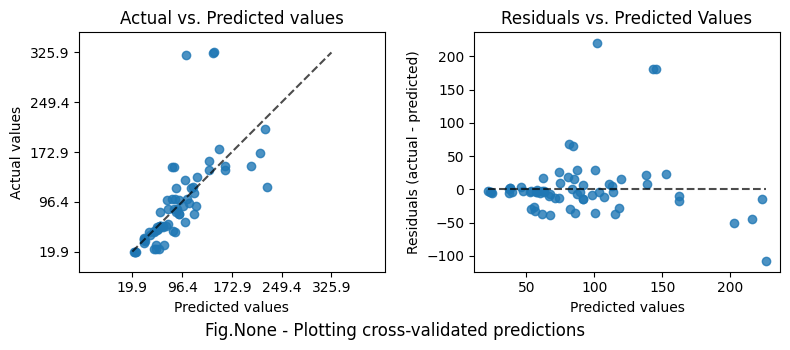

In [76]:
plot_actual_vs_predicted(np.exp(y_test), y_pred_test)

In [77]:
# Features and coefficients
coef_df = pd.DataFrame({'Coefficients': lasso.coef_}, index=lasso.feature_names_in_)
coef_df
# add the intercept coefficient
coef_df.loc['INTERCEPT'] = lasso.intercept_
display(coef_df.sort_values('Coefficients',ascending=False))

,Coefficients
INTERCEPT,4.151708
comp_2,0.321569
product_weight_logg,0.247921
freight_price,0.202157
...,...
product_name_lenght,-0.021489
ps2,-0.042485
fp3,-0.058377
fp2,-0.069861


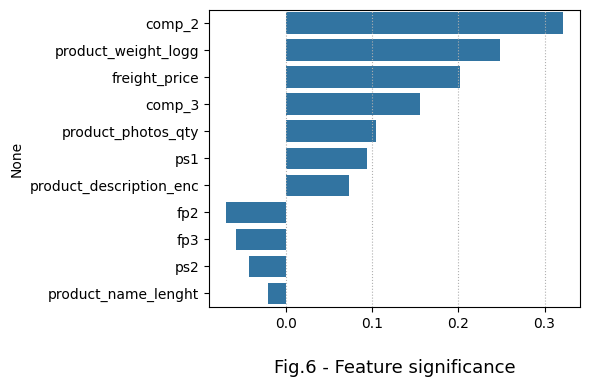

In [78]:
plot_counter = 6
idx = coef_df.sort_values(['Coefficients'], key=abs,ascending=False).index
temp= coef_df.reindex(idx).iloc[1:12]

fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(x=temp.values.flatten(), y=temp.index)

ax.set_title(f'Fig.{plot_counter} - Feature significance', y=-0.25, fontsize=13, loc='center')
ax.xaxis.grid(linestyle=':')
plt.tight_layout()

plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

### Polynomial

In [79]:
# Creation an instance
poly = PolynomialFeatures(degree=2, include_bias=False) #
#poly.fit(X_train)

# Generation of polynomial features for samples
X_train_poly, X_test_poly, X_valid_poly = poly.fit_transform(X_train), poly.transform(X_test), poly.transform(X_valid)

#Выводим результирующие размерности таблиц
print(X_train_poly.shape)
print(X_test_poly.shape)

(540, 299)
(68, 299)


In [80]:
# Creation an instance
lasso_lr_poly = linear_model.Lasso(alpha=0.005, random_state=random_seed)

# Train the Model
lasso_lr_poly.fit(X_train_poly, y_train)

# Predict target values
y_pred_test = lasso_lr_poly.predict(X_test_poly)
y_pred_test = np.exp(y_pred_test)

results['model_name'].append('polinomial')
results['MSE'].append(round(mean_squared_error(np.exp(y_test), y_pred_test),2))
results['MAPE'].append(round(mean_absolute_percentage_error(np.exp(y_test), y_pred_test)*100,2))

#print(f'MSE: {round(mean_squared_error(np.exp(y_test), y_pred_test),2)}')
print('MAPE: {:.2f} %'.format(mean_absolute_percentage_error(np.exp(y_test), y_pred_test)*100))

MAPE: 13.64 %


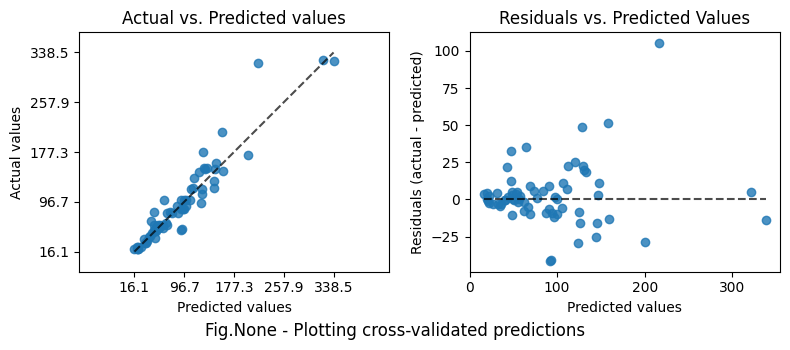

In [81]:
plot_actual_vs_predicted(np.exp(y_test), y_pred_test)

In [82]:
# # Features and coefficients
# coef_df = pd.DataFrame({'Coefficients': lasso_lr_poly.coef_}, index=lasso_lr_poly. )
# coef_df
# # add the intercept coefficient
# coef_df.loc['INTERCEPT'] = lasso_lr_poly.intercept_
# display(coef_df.sort_values('Coefficients',ascending=False))

# idx = coef_df.sort_values(['Coefficients'], key=abs,ascending=False).index
# temp= coef_df.reindex(idx).iloc[:15]#.sort_values('Coefficients', ascending=False)#[:10]
# sns.barplot(x=temp.values.flatten(),y=temp.index)
# plt.show()

### Elastic net

In [83]:
# Creation an instance
elnet = linear_model.ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000, random_state=random_seed)

# Train the Model
elnet.fit(X_train_poly, y_train)

# Predict target values
y_pred_test = np.exp(elnet.predict(X_test_poly))


results['model_name'].append('Elastic_net')
results['MSE'].append(round(mean_squared_error(np.exp(y_test), y_pred_test),2))
results['MAPE'].append(round(mean_absolute_percentage_error(np.exp(y_test), y_pred_test)*100,2))

print('MAPE: {:.2f} %'.format(mean_absolute_percentage_error(np.exp(y_test), y_pred_test)*100))

MAPE: 21.43 %


## Gradient boosting

In [84]:
gbr_cl = GradientBoostingRegressor(
    max_depth=5,
    n_estimators=300,
    random_state=random_seed 
)
# Model training
gbr_cl.fit(X_train, y_train)

# Predict target values
y_pred_train, y_pred_test = np.exp(gbr_cl.predict(X_train)), np.exp(gbr_cl.predict(X_test))

results['model_name'].append('Grad_boosting')
results['MSE'].append(round(mean_squared_error(np.exp(y_test), y_pred_test),2))
results['MAPE'].append(round(mean_absolute_percentage_error(np.exp(y_test), y_pred_test)*100,2))

print('MAPE: {:.2f} %'.format(mean_absolute_percentage_error(np.exp(y_test), y_pred_test)*100))

print("Train R^2: {:.3f}".format(r2_score(np.exp(y_train), y_pred_train)))
print("Test R^2: {:.3f}".format(r2_score(np.exp(y_test), y_pred_test)))

MAPE: 3.72 %
Train R^2: 1.000
Test R^2: 0.986


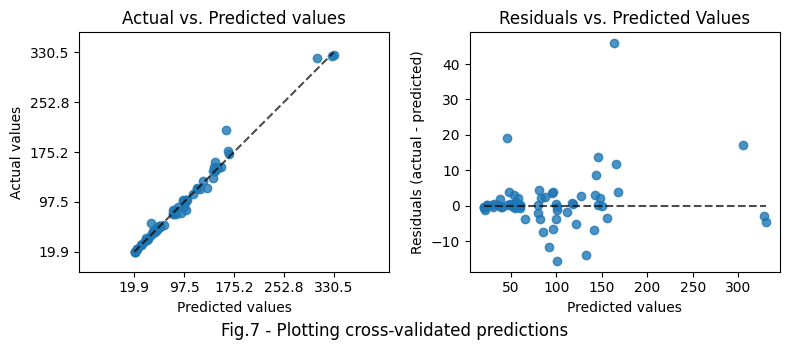

In [85]:
plot_actual_vs_predicted(np.exp(y_test), y_pred_test, 7)    

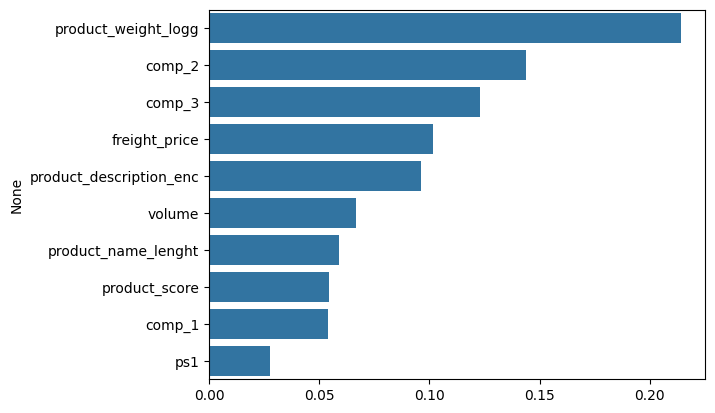

<Figure size 640x480 with 0 Axes>

In [86]:
plot_counter = 8

# Features and coefficients
coef_df = pd.DataFrame({'Coefficients': gbr_cl.feature_importances_}, index=gbr_cl.feature_names_in_)
#display(coef_df.sort_values('Coefficients',ascending=False))
temp = coef_df.sort_values('Coefficients', ascending=False).iloc[:10]
sns.barplot(x=temp.values.flatten(), y=temp.index)
plt.show()

plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

## models comparison

In [87]:
results = pd.DataFrame(results).set_index('model_name')
results.sort_values('MAPE')

,MSE,MAPE
model_name,,
Grad_boosting,60.73,3.72
polinomial,434.53,13.64
Elastic_net,1170.29,21.43
lin_reg_regularized,2309.34,27.46
lin_reg,3305.78,46.69


> The best model by the MAPE metric is gradient boosting.

# 3. Demand

In [88]:
#data[['qty','unit_price']] = data[['qty_log', 'unit_price_log']].apply(np.exp)

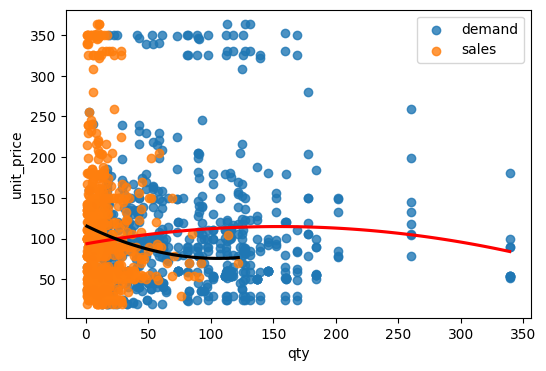

In [89]:
fig,ax = plt.subplots(figsize=(6,4))
sns.regplot(data, x='customers',  y='unit_price', order=2, line_kws={"color": "red"}, ci=None, label='demand')
sns.regplot(data, x='qty',  y='unit_price', order=2, line_kws={"color": "black"}, ci=None, label='sales')
ax.legend();

In [90]:
data[['customers', 'qty']].describe()

,customers,qty
count,676.000000,676.000000
mean,81.028107,14.495562
std,62.055560,15.443421
min,1.000000,1.000000
25%,34.000000,4.000000
50%,62.000000,10.000000
75%,116.000000,18.000000
max,339.000000,122.000000
